In [1]:
import numpy as np
import pfnet as pf
from scipy.sparse import triu,bmat,coo_matrix,eye,spdiags
import matplotlib.pyplot as plt
from scikits.sparse.cholmod import cholesky

%matplotlib inline  

In [2]:
net=pf.Network()
# net.load('PFNET-multi_period/data/ieee14.mat')
net.load('PFNET-multi_period/data/ieee300.mat')


In [3]:
penetration=50.
net.add_vargens(net.get_gen_buses(),#[net.get_bus(1)], 
                penetration, 50., 10, 0.1)

In [4]:
# Problem set up

total_load = sum([l.P for l in net.loads])
total_capacity=sum([gen.P_max for gen in net.generators])
uncertainty = 100.*sum([g.P_std for g in net.var_generators])/sum([g.P_max for g in net.var_generators])
corr_value = net.vargen_corr_value 
corr_radius = net.vargen_corr_radius

for br in net.branches:
    if br.ratingA==0:
        br.ratingA = 15

for gen in net.generators:
    gen.P_min = 0.
    gen.P_max = np.maximum(gen.P_max,0.)
    assert(gen.P_min <= gen.P_max)


num_w = net.num_buses-net.get_num_slack_buses() # voltage angles
num_p = net.get_num_P_adjust_gens()             #net.get_num_generators()         # adjustable generators
num_r = net.num_var_generators                       # renewable generators
num_bus = net.num_buses                         # buses
num_br = net.num_branches                       # branches
num_l = net.num_loads

In [5]:
capacity_per=np.array([0.23494860499265785, 0.30279001468428781, 0.18208516886930984, 0.23906020558002939, 0.041116005873715125])#([0.25, 0.50, 0.15, 0.05, 0.05 ])#
capacity_per_cumsum=np.cumsum(capacity_per)
sorted_gen=np.array(sorted([gen.P_max  for gen in net.generators]))
gen_cumsum=np.cumsum(sorted_gen)
gen_bounds=np.zeros(len(capacity_per)+1)
gen_bounds[0]=100
for idx,cap in enumerate(capacity_per_cumsum):
    gen_bounds[idx+1]=np.min(sorted_gen[gen_cumsum/total_capacity>=(1-cap)])
gen_bounds[-1]=0
parameters=[('Nuclear', 0.029917833750000022, 3.0741044999999803, 100, 400.0, 280.0, 280.0, 24.0, 168.0, 40000.0),
('Coal', 0.11954207142857155, 12.270104999999957, 140, 350.0, 140.0, 140.0, 5.0, 8.0, 12064.0),
('IGCC', 0.25331129032258076, 10.655729999999988, 54, 155.0, 70.0, 80.0, 16.0, 24.0, 2058.0),
('CCGT', 0.14437728426395943, 7.7242649999999946, 104, 197.0, 310.0, 310.0, 3.0, 4.0, 230.0),
('OCGT', 2.2680749999999974, 13.795700000000027, 8, 20.0, 90.0, 100.0, 1.0, 2.0, 46.0)]


In [6]:
# for i in range(0,len(gen_bounds)-1):
#     print np.sum([gen.P_max/total_capacity for gen in net.generators if gen.P_max>gen_bounds[i+1] and gen.P_max < gen_bounds[i] ])

In [7]:
min_down=np.zeros([num_p])
min_up=np.zeros([num_p])
ramp_up=np.zeros([num_p])
ramp_down=np.zeros([num_p])
on_off_cost=np.zeros([num_p])

gen_tech=np.chararray([num_p],itemsize=10)
for i in reversed(range(0,len(gen_bounds)-1)): 
    for gen in net.generators:
        if gen.P_max > gen_bounds[i+1] and gen.P_max <= gen_bounds[i]:
            aggregator= np.ceil(np.maximum(gen.P_max/(parameters[i][4]/net.base_power),1))
#             print aggregator,parameters[i][0],gen.index
            gen.P_max= aggregator*parameters[i][4]/net.base_power
            gen.P_min= aggregator*parameters[i][3]/net.base_power
            gen.cost_coeff_Q2= net.base_power**2*parameters[i][1]/aggregator
            gen.cost_coeff_Q1= net.base_power*parameters[i][2]/aggregator
            gen.dP_max= parameters[i][5]/net.base_power*aggregator
            
            ramp_up[gen.index]=(aggregator*parameters[i][5])/net.base_power
            ramp_down[gen.index]=(aggregator*parameters[i][6])/net.base_power
            min_down[gen.index]= parameters[i][7]
            min_up[gen.index] = parameters[i][8]
            on_off_cost[gen.index] =parameters[i][9]
            
            gen_tech[gen.index] = parameters[i][0]
            
name_techno=list(set([techno[0] for techno in parameters]))

In [8]:
# sorted([(gen.index , gen.P_max) for idx , gen in enumerate( net.generators)],
#        key = lambda x: float(x[1]),reverse=True)
    

In [9]:
net.clear_flags()
net.set_flags(pf.OBJ_BUS,
              pf.FLAG_VARS,
              pf.BUS_PROP_NOT_SLACK,
              pf.BUS_VAR_VANG)
net.set_flags(pf.OBJ_GEN,
              pf.FLAG_VARS,
              pf.GEN_PROP_P_ADJUST,
              pf.GEN_VAR_P)
net.set_flags(pf.OBJ_VARGEN,
              pf.FLAG_VARS,
              pf.VARGEN_PROP_ANY,
              pf.VARGEN_VAR_P)
net.set_flags(pf.OBJ_LOAD,
              pf.FLAG_VARS,
              pf.LOAD_PROP_ANY,
              pf.LOAD_VAR_P)

In [10]:
x = net.get_var_values()
Pw = net.get_var_projection(pf.OBJ_BUS,pf.BUS_VAR_VANG)
Pp = net.get_var_projection(pf.OBJ_GEN,pf.GEN_VAR_P)
Pr = net.get_var_projection(pf.OBJ_VARGEN,pf.VARGEN_VAR_P)
Pd = net.get_var_projection(pf.OBJ_LOAD,pf.LOAD_VAR_P)


In [11]:
pf_eq = pf.Constraint(pf.CONSTR_TYPE_DCPF,net)
pf_eq.analyze()
pf_eq.eval(x)
AA = pf_eq.A.copy()
bb = pf_eq.b.copy()

In [12]:
fl_lim = pf.Constraint(pf.CONSTR_TYPE_DC_FLOW_LIM,net)
fl_lim.analyze()
fl_lim.eval(x)
GG = fl_lim.G.copy()
hl = fl_lim.l.copy()
hu = fl_lim.u.copy()

In [13]:
cost = pf.Function(pf.FUNC_TYPE_GEN_COST,1.,net)
cost.analyze()
cost.eval(x)
H = (cost.Hphi + cost.Hphi.T - triu(cost.Hphi)) # symmetric
g = cost.gphi - H*x
l = net.get_var_values(pf.LOWER_LIMITS)
u = net.get_var_values(pf.UPPER_LIMITS)

In [14]:
p_max = Pp*u
p_min = Pp*l
w_max = 5*np.ones(num_w)
w_min = -5*np.ones(num_w)
r_max = Pr*u
r_base = Pr*x
z_max = hu
z_min = hl 
H0 = Pp*H*Pp.T # change costs
g0 = Pp*g
#H1 = self.H0*self.parameters['cost_factor']
g1 = np.zeros(num_p)
G = AA*Pp.T
R = AA*Pr.T
A = -AA*Pw.T
Dm = -AA*Pd.T
J = GG*Pw.T 
b = bb
ll= Pd*x #np.array([l.P for l in net.loads]) # check 

In [15]:
rr_cov = Pr*net.create_vargen_P_sigma(corr_radius,corr_value)*Pr.T
r_cov = (rr_cov+rr_cov.T-triu(rr_cov)).tocsc()
factor = cholesky(r_cov)
LL,D = factor.L_D()
P = factor.P()
PT = coo_matrix((np.ones(P.size),(P,np.arange(P.size))),shape=D.shape)
D = D.tocoo()
Dh = coo_matrix((np.sqrt(D.data),(D.row,D.col)),shape=D.shape)
L = PT*LL*Dh

In [16]:
from cvxpy import *
import mosek
import gurobi

In [17]:
load_data=np.genfromtxt('BPA_data/day0.csv',delimiter=',',names=True)
r_test=np.flipud(load_data['wind'])*total_load*(penetration/100)/num_r

In [33]:
np.random.seed(seed=100)
n_h=24
p=Variable(num_p,n_h)
w=Variable(num_w,n_h)
z=Variable(num_br,n_h)
s=Variable(num_r,n_h)
load=Variable(num_l,n_h)
Pforecast=total_load
Load_Penalty=1e6
# p_min = p_max*0.0
rampup = ramp_up #p_max/(H0.diagonal()/np.max(H0))*0.04 # p_max*0.01
rampdown=ramp_down #p_max/(H0.diagonal()/np.max(H0))*0.04 # p_max*0.01


In [34]:
(total_load/np.sum([gen.P_max for gen in net.generators]))/0.8

0.73227203117607498

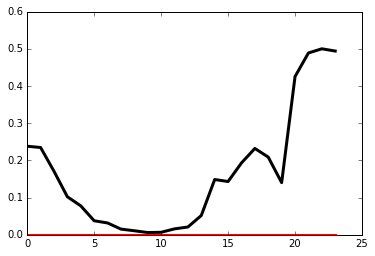

In [35]:
n_samples=50
scenarios=np.zeros([n_samples,n_h])
for j in range(n_samples):
    b=[]
    b=np.zeros([num_l,n_h])
    r=[]
    r=np.zeros([num_r,n_h])
    for i in range (n_h):
        b[:,i]=ll*load_data['load'][i]/load_data['load'][0]
        r[:,i]=0*np.minimum(np.maximum(r_test[i]*np.ones(num_r)
                                     +L*np.random.randn(num_r)*np.sqrt(r_test[i])*np.sqrt((i*1.+1)/(n_h)),1e-3),r_max)
    scenarios[j,:]=sum(r)
    plt.plot(sum(r)/total_load,color='gray')

plt.plot(np.mean(scenarios,0)/total_load,color='r',linewidth=3.0)
plt.plot(r_test*num_r/total_load,color='k',linewidth=3.0)
plt.show()

In [36]:
Constraints=[]
for i in range (n_h):
    
#     Constraints.append(G*p[:,i]-A*w[:,i]-b[:,i]==0)
#     Constraints.append(G*p[:,i]-A*w[:,i]==load[:,i])
    Constraints.append(G*p[:,i]+R*s[:,i]-A*w[:,i]==Dm*load[:,i])
    Constraints.append(J*w[:,i]==z[:,i])
    Constraints.append(p[:,i]<=p_max)
    Constraints.append(p[:,i]>=p_min)
    Constraints.append(w[:,i]<=w_max)
    Constraints.append(w[:,i]>=w_min)
    Constraints.append(z[:,i]<=z_max)
    Constraints.append(z[:,i]>=z_min)
    Constraints.append(s[:,i]<=r[:,i])
    Constraints.append(s[:,i]>=0)
    
#     Constraints.append(load[:,i]>=0)
    Constraints.append(load[:,i]<=b[:,i])




In [37]:
for i in range(1,n_h):
    for j in range (num_p):
        Constraints.append(p[j,i]-p[j,i-1]<=rampup[j])
        Constraints.append(p[j,i]-p[j,i-1]>=-rampdown[j])

In [38]:
Objective=0
for i in range (n_h):
    Objective=Objective + quad_form(p[:,i],H0*0.5)
    Objective=Objective + g0*p[:,i]# check 
    Objective=Objective + Load_Penalty*norm(load[:,i]-b[:,i],1)
   

In [39]:
prob = []
prob = Problem(Minimize(Objective), Constraints)

In [40]:
prob.solve(solver=MOSEK)

12609938.018686436

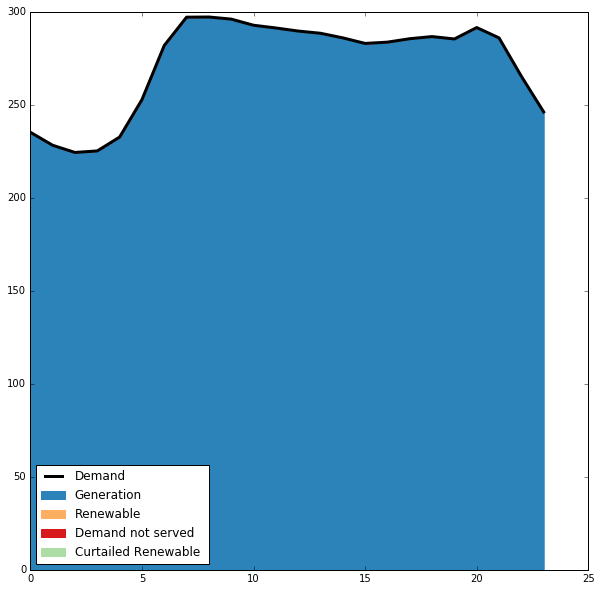

In [41]:
colors=['#d7191c','#fdae61','#abdda4','#2b83ba'] #['#ef8a62','#f7f7f7','#67a9cf','#008837']
plt.figure(figsize=(10,10))
plt.fill_between(range(n_h),np.zeros(n_h),np.squeeze(np.asarray(sum(p.value))),color=colors[3])
plt.fill_between(range(n_h),np.squeeze(np.asarray(sum(p.value))),
                 np.squeeze(np.asarray(sum(p.value)+sum(s.value))),
                 color=colors[1])

plt.fill_between(range(n_h),np.squeeze(np.asarray(sum(b))),
                 np.squeeze(np.asarray(sum(load.value))),
                 color=colors[0])
plt.plot(range(n_h),np.squeeze(np.asarray(sum(b))),color='k',linewidth=3.0)
plt.fill_between(range(n_h),np.zeros(n_h),-np.squeeze(np.asarray(-sum(s.value)+sum(r))),color=colors[2])
plt.legend(['Demand','Generation','Renewable','Demand not served','Curtailed Renewable '],loc='best')
plt.show()

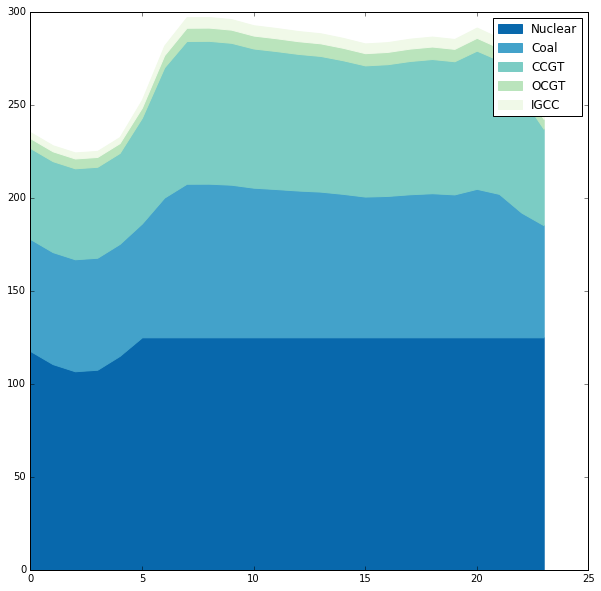

In [42]:
total_p_gen=np.sum(p.value,1)
total_share=[]

for name in name_techno:
    total_share.append((name,np.sum([ total_p_gen[i] for i in range(num_p) if gen_tech[i]==name  ])))
sorted_name_techno=[x[0] for x in sorted(total_share,key =lambda x: x[1],reverse=True)]
colors=list(reversed(['#f0f9e8','#bae4bc','#7bccc4','#43a2ca','#0868ac']))
share_per_hour=np.zeros([len(name_techno)+1,n_h])
plt.figure(figsize=(10,10))
for idx,name in enumerate(sorted_name_techno):
    share_per_hour[idx+1]=np.sum([ np.squeeze(np.asarray(p.value[i])) for i in range(num_p) if gen_tech[i]==name ],0)
share_per_hour=np.cumsum(share_per_hour,0)
for idx,name in enumerate(sorted_name_techno):
    plt.fill_between(range(n_h),share_per_hour[idx],share_per_hour[idx+1],color=colors[idx])
plt.legend(sorted_name_techno,loc='best')
plt.show()

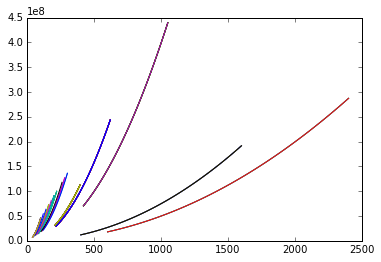

In [28]:
n_points=50
for gen_id in range(num_p):
#     gen_id=10
    xx=np.linspace(p_min[gen_id]*net.base_power,p_max[gen_id]*net.base_power,n_points)
    y=np.zeros(n_points)
    for i in range(n_points):
        y[i]=0.5*H0.diagonal()[gen_id]*xx[i]**2+g0[gen_id]*xx[i]
    plt.plot(xx,y)

In [63]:
assert((p.value<=np.transpose([p_max*1.1 for i in range (n_h)])).all())
assert((p.value>=np.transpose([p_min[0]*0.9 for i in range (n_h)])).all())
assert((w.value<=np.transpose([w_max for i in range (n_h)])).all())
assert((w.value>=np.transpose([w_min for i in range (n_h)])).all())
assert((z.value<=np.transpose([z_max for i in range (n_h)])).all())
assert((z.value>=np.transpose([z_min for i in range (n_h)])).all())
